In [5]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from tqdm import tqdm

In [6]:
class GridWorld:
    def __init__(self, size = 100, max_step = 500):
        self.size = size
        self.max_step = max_step
        self.start_zone = (0, 10)
        self.terminal_zone = (90, 100)
        self.reset()
        
    def reset(self):
        x = np.random.uniform(self.start_zone[0], self.start_zone[1])
        y = np.random.uniform(self.start_zone[0], self.start_zone[1])
        
        self.state = (x, y)
        self.steps = 0
        
    def step(self, action): # dtype = list, integer, bool
        self.steps += 1
        reward = -1     # default
        
        if action == "up" and self.state[1] < self.size - 1:
            self.state = (self.state[0], self.state[1] + 1)
        elif action == "down" and self.state[1] > 0:
            self.state = (self.state[0], self.state[1] - 1)
        elif action == "right" and self.state[0] < self.size - 1:
            self.state = (self.state[0] + 1, self.state[1])
        elif action == "left" and self.state[0] > 0:
            self.state = (self.state[0] - 1, self.state[1])
        
        stop = False
        
        if self.state[0] >= self.terminal_zone[0] and self.state[1] >= self.terminal_zone[0]:
            stop = True
            reward = 0            
        elif self.steps == self.max_step:
            stop = True
    
        return self.state, reward, stop

In [7]:
class FourierEstimator:
    def __init__(self, env, n, alpha):
        self.n = n                                  # Fourier order
        self.k = 2                                  # State Dimension (x, y)
        self.n_action = 4                           # number of actions
        self.alpha = alpha                          # base learning rate
        self.w = np.zeros([pow(self.n+1, self.k), self.n_action])
        self.env = env
        self.alpha_vec = self.setting_alphas()
        
    def setting_alphas(self):
        orders = list(range(self.n + 1))            # orders {0, 1, ..., n}
        c = list(product(orders, repeat = self.k))  # (n+1)^k Cartesian Products
        norm_c = np.linalg.norm(c, axis = 1)        # (n+1)^k norms
        norm_c[0] = 1.
        return self.alpha / norm_c                  # shape ((n+1)^k)
    
    def normalize(self, state):
        norm_state = np.empty(np.shape(state))
        min_state = np.array([0, 0])                         # Minimun Start Zone (0,0)
        max_state = np.array([self.env.size, self.env.size]) # Maximum Size
        
        state_range = max_state - min_state
        norm_state = (state - min_state) / state_range
        
        return norm_state
    
    def get_features(self, state):
        norm_state = self.normalize(state)
        orders = list(range(self.n + 1))             # orders {0, 1, ..., n} 
        c = list(product(orders, repeat=self.k))     # (n+1)^k Cartesian products
        return np.cos(np.pi * np.dot(c, norm_state)) # (n+1)^k features
    
    def predict_values(self, state):
        return np.dot(self.w.T, self.get_features(state))
    
    def update_weights(self, state, action, target):
        q_values = self.predict_values(state)
        current_q = q_values[action]
        delta = target - current_q
        features = self.get_features(state)
        self.w[:, action] += delta * self.alpha_vec * features

In [8]:
def get_action(state, estimator, epsilon):
    if np.random.rand(1) < epsilon:
        values = np.random.randint(4)
    else:
        values = np.argmax(estimator.predict_values(state))
    return values

In [9]:
def semi_gradient_sarsa(env, estimator, num_episodes, gamma, epsilon):
    step_counts = []
    for episode in tqdm(range(num_episodes)):
        env.reset()
        state = env.state
        step_count = 0
        
        for _ in range(env.max_step):
            step_count += 1 # 필요없는 변수 선언, _ 를 사용하면 됨
            action = get_action(state, estimator, epsilon)
            next_state, reward, stop = env.step(["up", "down", "right", "left"][action])
            
            if stop:
                target = reward
            else:
                next_action = np.argmax(estimator.predict_values(state))
                target = reward + gamma * estimator.predict_values(next_state)[next_action]
                
            estimator.update_weights(state, action, target)
            
            if stop:
                break
            
            state = next_state
            action = next_action
            
        step_counts.append(step_count)  # step_count -> _ + 1로 바꾸면 object 한개 아낌. Nice!
    
    return step_counts

In [10]:
# Hyperparameters
size = 100              # Grid Size
n = 4                   # Fourier order
alpha = 0.01            # Learning rate
epsilon = 0.1           # e-greedy probability
gamma = 0.99            # discount factor
num_episodes = 1000     

In [11]:
gridworld = GridWorld()
estimator = FourierEstimator(env=gridworld, n=n, alpha=alpha)

In [12]:
num_step = semi_gradient_sarsa(gridworld, estimator, num_episodes, gamma, epsilon)

100%|██████████| 1000/1000 [00:41<00:00, 24.03it/s]


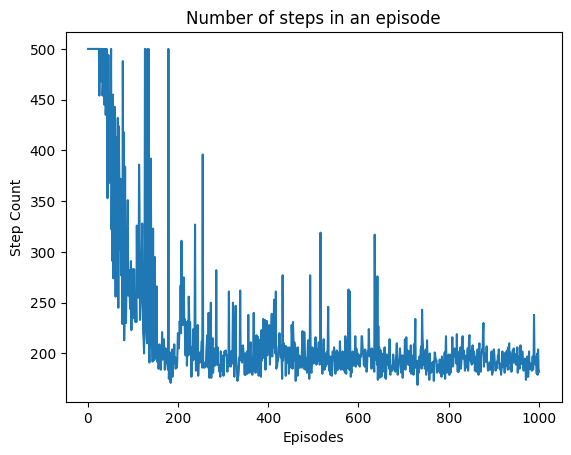

In [13]:
plt.plot(range(1, num_episodes + 1), num_step)
plt.xlabel("Episodes")
plt.ylabel("Step Count")
plt.title("Number of steps in an episode")
plt.show()

Start location is (0.426, 7.008)
Terminal location is (90.426, 90.008)
Number of actions : 173


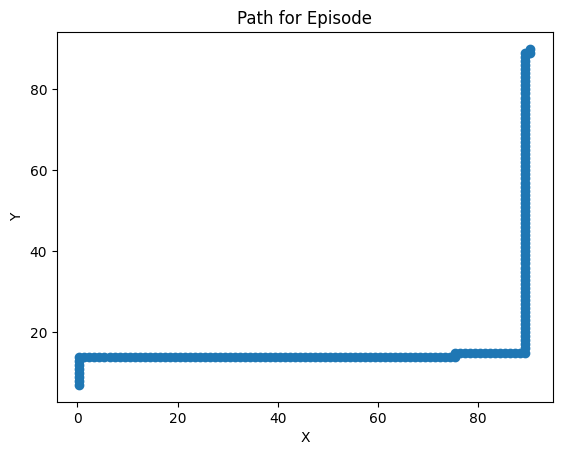

In [15]:
gridworld.reset()           # 학습된 gridworld class에서 테스트
state = gridworld.state
print(f'Start location is ({state[0]:.3f}, {state[1]:.3f})')

path = [state]
action_count = 0

for _ in range(gridworld.max_step):
    action_count += 1
    action = np.argmax(estimator.predict_values(state))
    next_state, _, stop = gridworld.step(["up", "down", "right", "left"][action])
    path.append(next_state)
    if stop:
        break
    state = next_state

print(f'Terminal location is ({next_state[0]:.3f}, {next_state[1]:.3f})') 
print(f'Number of actions : {action_count}')
   
# Plot optimal path
x, y = [state[0] for state in path], [state[1] for state in path]

plt.plot(x, y, '-o')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Path for Episode")
plt.show()